<a href="https://colab.research.google.com/github/Syedboo/Stock-Prediction-Using-News-Sentiment/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Historical Data - Extracting data and Merging them**

---



In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install -q transformers torch


In [28]:
import json
from datetime import datetime
import pandas as pd
from transformers import pipeline, logging

# Suppress warnings from Hugging Face transformers library
logging.set_verbosity_error()

# Explicitly initialize the sentiment analysis pipeline with a specific model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Load the articles data from JSON file
with open('/content/sample_data/articles_data_sainsb.json', 'r') as file:
    articles = json.load(file)

# Process articles to extract and convert dates
for article in articles:
    # Check if the date field exists and is not empty
    if "date" in article and article["date"]:
        # Convert the date into datetime object
        date_time = datetime.strptime(article["date"], "%a, %d %b %Y %H:%M:%S GMT")

        # Extract the actual date and time
        # Convert date object to ISO format string for JSON serialization
        article["actual_date"] = date_time.date().isoformat()  # Changed this line
        article["time"] = date_time.time().strftime("%H:%M:%S")

        # Truncate the text to the maximum length allowed by the model
        text = article["text"][:512]

        # Get sentiment analysis results
        sentiment_result = sentiment_pipeline(text)[0]

        # Convert the sentiment label to a score between 0 and 1
        sentiment_label = sentiment_result['label']
        sentiment_score = sentiment_result['score']
        if sentiment_label == "NEGATIVE":
            sentiment_score = 1 - sentiment_score  # Invert score for negative sentiment

        # Assign sentiment score to the article
        article["sentiment_score"] = sentiment_score
        article["insights"] = sentiment_result['label']
    else:
        # Handle missing dates (e.g., set to None, skip, etc.)
        article["actual_date"] = None
        article["time"] = None
        article["sentiment_score"] = None
        article["insights"] = None

# Save processed articles to a new JSON file
with open('processed_articles_data.json', 'w') as file:
    json.dump(articles, file, indent=4)


**2. Load Historical Stock Price Data**

In [29]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the stock symbol and time period
stock_symbol = 'SBRY.L'
end_date = datetime.now()
start_date = end_date - timedelta(days=365)



# Fetch the stock data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Save the data to a CSV file
csv_file = 'sbrl_l_stock_data.csv'
stock_data.to_csv(csv_file)

# Load stock price data from CSV
stock_data = pd.read_csv(csv_file)

# Ensure the date column is in datetime format
# The date column is not explicitly saved, so we create one from the index
stock_data['Date'] = pd.to_datetime(stock_data.index)

# Drop the old index column if it exists
stock_data.reset_index(drop=True, inplace=True)

# Sort by date for consistency
stock_data = stock_data.sort_values(by='Date')

# Save the sorted data back to a CSV file
sorted_csv_file = 'sbrl_l_stock_data_sorted.csv'
stock_data.to_csv(sorted_csv_file, index=False)

print(f"Stock data for {stock_symbol} has been saved to {csv_file} and sorted data saved to {sorted_csv_file}")


[*********************100%***********************]  1 of 1 completed

Stock data for SBRY.L has been saved to sbrl_l_stock_data.csv and sorted data saved to sbrl_l_stock_data_sorted.csv


In [30]:
# Load stock price data from CSV
stock_data = pd.read_csv('/content/sbrl_l_stock_data.csv')

# Ensure the date column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Sort by date for consistency
stock_data = stock_data.sort_values(by='Date')


**3. Merge historical data**

In [31]:
import json

# Load articles with sentiment and insights
with open('processed_articles_data.json', 'r') as file:
    articles = json.load(file)

# Convert articles to DataFrame
articles_df = pd.DataFrame(articles)

# Convert the 'actual_date' column to datetime
articles_df['actual_date'] = pd.to_datetime(articles_df['actual_date'])

# Merge the stock data with articles data on date
merged_df = pd.merge(stock_data, articles_df, left_on='Date', right_on='actual_date', how='left')

# Save the merged data to a new CSV file
merged_df.to_csv('merged_stock_articles_data.csv', index=False)


**4. Forward fill**

In [32]:
import pandas as pd

# Load the merged data with missing values
merged_df = pd.read_csv('/content/merged_stock_articles_data.csv')

# Forward fill missing values for sentiment_score and other columns
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(method='ffill')
merged_df['insights'] = merged_df['insights'].fillna(method='ffill')
merged_df['text'] = merged_df['text'].fillna(method='ffill')
merged_df['title'] = merged_df['title'].fillna(method='ffill')

# Impute remaining null values in sentiment_score with 0.5
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.5)

# Save the updated dataset
merged_df.to_csv('merged_stock_articles_data_filled_forward.csv', index=False)

print("Missing values have been forward filled and sentiment_score nulls imputed with 0.5.")


Missing values have been forward filled and sentiment_score nulls imputed with 0.5.


# Building the model

**Step 1: Prepare the Data**

In [33]:
import pandas as pd

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Display the first few rows of the data
print(data.head())


                  Open  sentiment_score        High         Low       Close
Date                                                                       
2023-10-04  247.899994         0.500000  256.000000  246.800003  254.100006
2023-10-05  254.699997         0.500000  259.600006  254.199997  256.399994
2023-10-06  257.100006         0.007185  258.209991  249.899994  253.899994
2023-10-09  249.199997         0.007185  254.199997  249.199997  250.600006
2023-10-10  253.199997         0.007185  258.299988  252.500000  257.200012


**2. Training Random Forest model**

MSE: 7.851238665294188
MAE: 2.228937104748138
RMSE: 2.8020061858058396


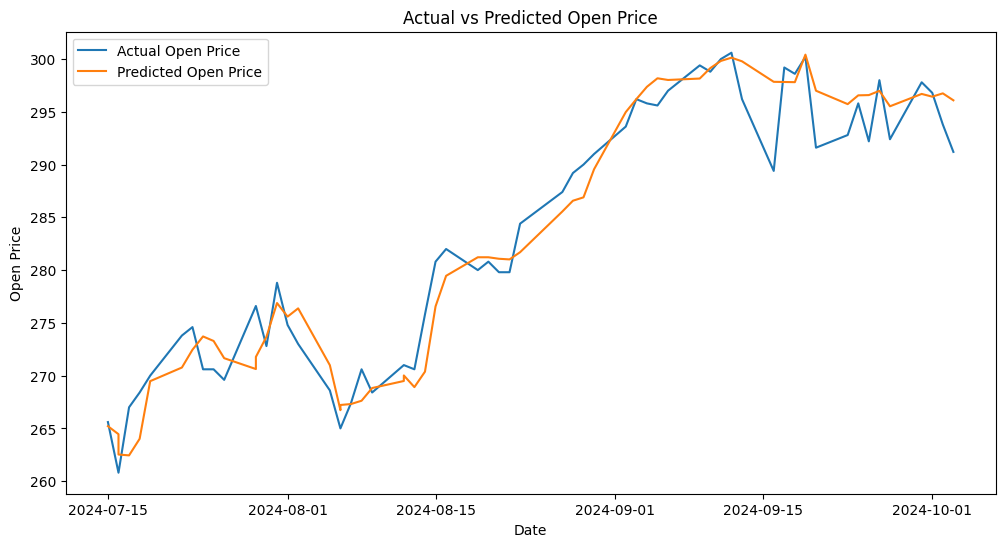

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Replace with your data file path

# The 'Date' column is already the index, no need to convert and set it again.
#data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date', inplace=True)
#data.sort_index(inplace=True)

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()

# Adding Moving Averages
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()

# Adding Volatility
data['Volatility'] = data['Open'].rolling(window=10).std()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns, index=data.index)

#print(data_imputed.head())
data_imputed.to_csv('Stock_price_dataset.csv', index=False)
# Select features and target
features = ['sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_roll_mean_3', 'sentiment_roll_std_3',
            'open_roll_mean_3', 'open_roll_std_3', 'MA10', 'MA50', 'Volatility']
target = 'Open'

# Train-test split
train_size = int(len(data_imputed) * 0.8)
train = data_imputed[:train_size]
test = data_imputed[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Model Training with Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)

print(f'MSE: {rf_mse}')
print(f'MAE: {rf_mae}')
print(f'RMSE: {rf_rmse}')

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Open Price')
plt.plot(test.index, y_pred, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

Modifying the above code to include signals

MSE: 8.664846347779719
MAE: 2.089302378336585
RMSE: 2.943611106749619
Day 0: Buy - Predicted increase of 2.51% by Day 3
Day 1: Buy - Predicted increase of 2.02% by Day 3
Day 2: Buy - Predicted increase of 3.35% by Day 6
Day 3: Buy - Predicted increase of 2.76% by Day 6
Day 4: Buy - Predicted increase of 2.46% by Day 6
Day 5: Buy - Predicted increase of 2.14% by Day 6
Day 6: Hold - No significant change found
Day 7: Hold - No significant change found
Day 8: Hold - No significant change found
Day 9: Hold - No significant change found
Day 10: Hold - No significant change found
Day 11: Hold - No significant change found
Day 12: Hold - No significant change found
Day 13: Hold - No significant change found
Day 14: Hold - No significant change found
Day 15: Hold - No significant change found
Day 16: Hold - No significant change found
Day 17: Hold - No significant change found
Day 18: Hold - No significant change found
Day 19: Hold - No significant change found
Day 20: Hold - No significant ch

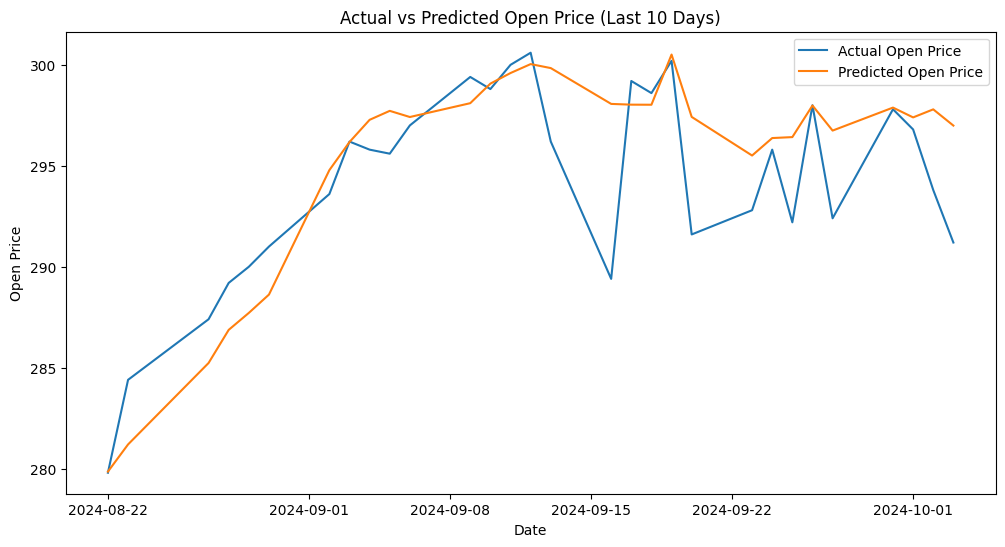

Model saved to random_forest_model.pkl


In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()

# Adding Moving Averages
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()

# Adding Volatility
data['Volatility'] = data['Open'].rolling(window=10).std()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns, index=data.index)

# Select features and target
features = ['sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_roll_mean_3', 'sentiment_roll_std_3',
            'open_roll_mean_3', 'open_roll_std_3', 'MA10', 'MA50', 'Volatility']
target = 'Open'

# Define the number of days for testing
test_days = 30  # You can adjust this value as needed

# Train-test split
train_size = len(data_imputed) - test_days
train = data_imputed[:train_size]
test = data_imputed[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Model Training with Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Model Evaluation
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)

print(f'MSE: {rf_mse}')
print(f'MAE: {rf_mae}')
print(f'RMSE: {rf_rmse}')

# Function to calculate trading signals
def trading_signal(predicted_prices, threshold=0.02):
    """
    Generate trading signals based on predicted prices.

    :param predicted_prices: List or array of predicted prices.
    :param threshold: The percentage change threshold to consider.
    :return: List of signals indicating 'buy', 'sell', or 'hold'.
    """
    signals = []
    n = len(predicted_prices)

    for i in range(n - 1):
        signal_found = False
        for j in range(i + 1, n):
            # Calculate percentage change
            change = (predicted_prices[j] - predicted_prices[i]) / predicted_prices[i]
            if abs(change) > threshold:
                # Determine signal based on change direction
                if change > 0:
                    signals.append(f"Day {i}: Buy - Predicted increase of {change*100:.2f}% by Day {j}")
                else:
                    signals.append(f"Day {i}: Sell - Predicted decrease of {change*100:.2f}% by Day {j}")
                signal_found = True
                break

        if not signal_found:
            signals.append(f"Day {i}: Hold - No significant change found")

    return signals

# Call the trading_signal function with predicted prices
signals = trading_signal(y_pred)

# Output the signals
for signal in signals:
    print(signal)

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Open Price')
plt.plot(test.index, y_pred, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price (Last 10 Days)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

import joblib

# Save the model
model_filename = 'random_forest_model.pkl'
joblib.dump(model, model_filename)
print(f'Model saved to {model_filename}')



In [11]:
import numpy as np
import requests
from lxml import html
from datetime import datetime, timedelta
from transformers import pipeline
import re
import json


# Load the model
loaded_model = joblib.load("/content/random_forest_model.pkl")
print(f'Model loaded from {model_filename}')

import pandas as pd
from sklearn.impute import SimpleImputer

def forecast_next_days_lstm(new_sentiment_score, model, initial_data, features, imputer, days=1):
    """
    Forecast the next `days` days based on the initial data using the provided model.

    :param model: The trained model.
    :param initial_data: DataFrame containing the latest data for prediction.
    :param features: List of feature names used in the model.
    :param imputer: The imputer used to handle missing values.
    :param days: Number of days to forecast.
    :return: List of forecasts for the next `days` days.
    """
    forecasts = []
    data = initial_data.copy()

    for _ in range(days):
        # Prepare features for prediction
        latest_features = data[features].values

        # Ensure no NaN values
        latest_features = imputer.transform(latest_features)

        # Predict the next day's price
        next_day_price = model.predict(latest_features)[0]
        forecasts.append(next_day_price)

        # Update the data with the new prediction
        new_row = data.iloc[-1:].copy()
        new_row['Open'] = next_day_price
        new_row['sentiment_lag_1'] = new_sentiment_score
        new_row['sentiment_lag_2'] = data['sentiment_score'].iloc[-1]
        new_row['sentiment_roll_mean_3'] = data['sentiment_score'].iloc[-3:].mean()
        new_row['sentiment_roll_std_3'] = data['sentiment_score'].iloc[-3:].std()
        new_row['open_roll_mean_3'] = data['Open'].iloc[-3:].mean()
        new_row['open_roll_std_3'] = data['Open'].iloc[-3:].std()
        new_row['MA10'] = data['Open'].iloc[-10:].mean()
        new_row['MA50'] = data['Open'].iloc[-50:].mean()
        new_row['Volatility'] = data['Open'].iloc[-10:].std()

        # Append new_row to data
        data = pd.concat([data, new_row], ignore_index=True)

    return forecasts

# Example usage
initial_data = data_imputed.iloc[-1:]  # Latest row of data
forecast_days = 1

print(initial_data)

#To extract recent news and apphend it to predict tomorrow's price

# Define the URL
url = 'https://news.google.com/search?q=sainsburys&hl=en-GB&gl=GB&ceid=GB%3Aen'

# Make a request to the website
response = requests.get(url)

# Parse the page content
tree = html.fromstring(response.content)

# Define the XPaths
title_xpath = "//div[@class='UW0SDc']//a//text()"
time_xpath = "//div[@class='UW0SDc']//time//text()"

# Extract data using XPath
titles = tree.xpath(title_xpath)
times = tree.xpath(time_xpath)


# Helper function to format dates
def format_time(time_str):
    time_str = time_str.strip()

    if time_str.lower() == 'yesterday':
        return (datetime.now() - timedelta(days=1)).strftime('%d %b %Y')

    if 'hours ago' in time_str:
        hours_ago = int(time_str.split()[0])
        return (datetime.now() - timedelta(hours=hours_ago)).strftime('%d %b %Y')

    if 'days ago' in time_str:
        days_ago = int(time_str.split()[0])
        return (datetime.now() - timedelta(days=days_ago)).strftime('%d %b %Y')

    # Handle dates in 'd MMM' format (e.g., '13 Jul')
    try:
        return datetime.strptime(time_str, '%d %b').replace(year=datetime.now().year).strftime('%d %b %Y')
    except ValueError:
        # Handle dates in 'd MMM yyyy' format (e.g., '9 Dec 2023')
        try:
            return datetime.strptime(time_str, '%d %b %Y').strftime('%d %b %Y')
        except ValueError:
            return time_str  # Return the original string if parsing fails


# Combine titles and times into a list of tuples
results = list(zip(titles, times))


def parse_time(time_str):
    """Convert a time string into a datetime object."""
    now = datetime.now()

    # Check for relative times
    relative_time_match = re.match(r'(\d+) hours? ago', time_str)
    if relative_time_match:
        hours_ago = int(relative_time_match.group(1))
        return now - timedelta(hours=hours_ago)

    # Check for absolute dates
    try:
        return datetime.strptime(time_str, "%d %b %Y")
    except ValueError:
        raise ValueError(f"Unrecognized time format: {time_str}")


# Step 1: Find the most recent date
most_recent_title = None
most_recent_time = None


for title, time_str in results:
    try:
        time_obj = parse_time(time_str)
        if most_recent_time is None or time_obj > most_recent_time:
            most_recent_time = time_obj
            most_recent_title = title
    except ValueError as e:
        pass  # Print error for unrecognized formats



# Step 3: Get sentiment score using transformers
if most_recent_title:
    sentiment_pipeline = pipeline("sentiment-analysis")
    sentiment_result = sentiment_pipeline(most_recent_title)
    sentiment_score = sentiment_result[0]['score']
    sentiment_label = sentiment_result[0]['label']
    if sentiment_label == "NEGATIVE":
        sentiment_score = 1 - sentiment_score
    #print(f"Sentiment Score: {sentiment_score}")

else:
    #Neutral
    sentiment_score = 0.5




#Updating the news to articles_data file for future predictions
# Path to the JSON file
file_path = '/content/sample_data/articles_data_sainsb.json'

# New details
new_title = most_recent_title
new_author = "N/A"
new_text = most_recent_title
new_url = "N/A"

# Get today's date in the required format
today_date = datetime.now().strftime("%a, %d %b %Y %H:%M:%S GMT")

# Create a new dictionary with the details
new_article = {
    "title": new_title,
    "author": new_author,
    "date": today_date,
    "text": new_text,
    "url": new_url
}

# Load the existing data from the JSON file
with open(file_path, 'r') as file:
    articles = json.load(file)

# Append the new article to the list
articles.append(new_article)

# Write the updated list back to the JSON file
with open(file_path, 'w') as file:
    json.dump(articles, file, indent=4)

#print("New article added to the JSON file.")
#DONE - Updating the news to articles_data file for future predictions

new_sentiment_score = sentiment_score
# Initialize the imputer (use the one from your training process)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform the initial data
imputer.fit(data_imputed[features])
future_prices = forecast_next_days_lstm(new_sentiment_score, loaded_model, initial_data, features, imputer, days=forecast_days)
print(f"Forecasted price for the next {forecast_days} day: {future_prices}")


Model loaded from random_forest_model.pkl
                  Open  sentiment_score        High         Low       Close  \
Date                                                                          
2024-10-03  291.200012         0.996984  293.799988  287.600006  292.799988   

            sentiment_lag_1  sentiment_lag_2  sentiment_roll_mean_3  \
Date                                                                  
2024-10-03         0.996984         0.996984               0.996984   

            sentiment_roll_std_3  open_roll_mean_3  open_roll_std_3  \
Date                                                                  
2024-10-03                   0.0        293.933329         2.802368   

                  MA10        MA50  Volatility  
Date                                            
2024-10-03  294.239996  285.951998    2.620935  


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Forecasted price for the next 1 day: [296.99199645996094]


**Trying with LSTM**

Shape of X_train: (160, 60, 14), Shape of y_train: (160,)
Shape of X_test: (41, 60, 14), Shape of y_test: (41,)
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - loss: 0.0418 - val_loss: 0.0710
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0173 - val_loss: 0.0076
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.0119 - val_loss: 0.0465
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.0099 - val_loss: 0.0348
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0068 - val_loss: 0.0377
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0065 - val_loss: 0.0712
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0053 - val_loss: 0.0450
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0054 - val_loss: 0.0476
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.0057 - val_loss: 0.0405
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0051 - val_loss: 0.0368
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/

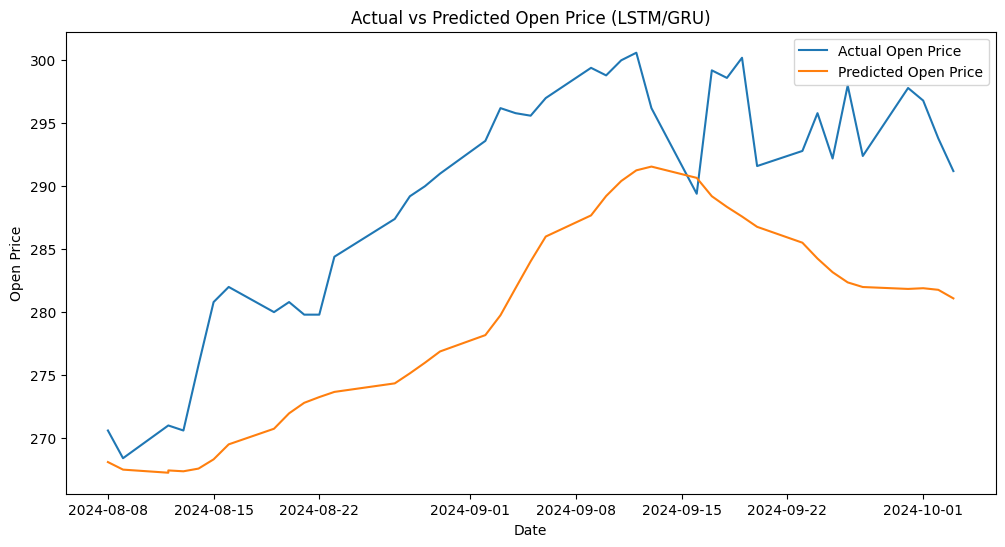

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()
data['Volatility'] = data['Open'].rolling(window=10).std()

# Drop missing values after feature engineering
data.dropna(inplace=True)

# Scaling the features for LSTM/GRU
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Creating sequences (input and target for LSTM/GRU)
def create_sequences(data, target_column, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, target_column])  # Target is the 'Open' price
    return np.array(X), np.array(y)

# Set target column index (here, 'Open' is the 0th column)
target_column = 0
sequence_length = 60

X, y = create_sequences(scaled_data, target_column, sequence_length)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM/GRU input (samples, time steps, features)
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

# Build the LSTM/GRU Model
model = Sequential()

# LSTM or GRU layers (you can switch between LSTM and GRU by replacing the respective layer)
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Alternatively, use GRU instead of LSTM:
# model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(GRU(units=100, return_sequences=False))
# model.add(Dropout(0.2))

# Output layer (single output for the 'Open' price)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

lstmmodel = model

# Predict on test data
y_pred = model.predict(X_test)

# Inverse scaling to get the original price
y_test_scaled = np.zeros((len(y_test), scaled_data.shape[1]))
y_test_scaled[:, target_column] = y_test
y_test_original = scaler.inverse_transform(y_test_scaled)[:, target_column]

y_pred_scaled = np.zeros((len(y_pred), scaled_data.shape[1]))
y_pred_scaled[:, target_column] = y_pred.flatten()
y_pred_original = scaler.inverse_transform(y_pred_scaled)[:, target_column]

# Model Evaluation
lstm_mse = mean_squared_error(y_test_original, y_pred_original)
lstm_mae = mean_absolute_error(y_test_original, y_pred_original)
lstm_rmse = np.sqrt(lstm_mse)

print(f'MSE: {lstm_mse}')
print(f'MAE: {lstm_mae}')
print(f'RMSE: {lstm_rmse}')

def forecast_next_days_lstm(new_sentiment_score, lstm_model, initial_data, features, imputer, days=5):
    """
    Forecast stock prices for the next `days` using an LSTM model.

    :param new_sentiment_score: New sentiment score or features for forecasting.
    :param lstm_model: Trained LSTM model.
    :param initial_data: Initial data to start the forecasting process.
    :param features: Feature columns used by the model.
    :param imputer: Imputer used for missing values.
    :param days: Number of days to forecast.
    :return: List of forecasted prices.
    """
    import numpy as np

    # Ensure the new sentiment score is included in the features
    new_data = initial_data.copy()
    new_data['sentiment_score'] = new_sentiment_score

    # Impute any missing values in the new data
    new_data_imputed = imputer.transform(new_data[features])

    # Reshape the data for LSTM (samples, timesteps, features)
    input_data = np.array(new_data_imputed)
    input_data = input_data.reshape((1, input_data.shape[0], input_data.shape[1]))

    # Generate future predictions
    forecasted_prices = []
    for _ in range(days):
        # Predict the next day's price
        predicted_price = lstm_model.predict(input_data)
        forecasted_prices.append(predicted_price[0][0])  # Extract the price value

        # Update the input data by shifting and adding the new prediction
        next_input = np.append(input_data[:, 1:, :], [[predicted_price]], axis=1)
        input_data = next_input

    return forecasted_prices


# Plot Actual vs Predicted Open Price
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_original, label='Actual Open Price')
plt.plot(data.index[-len(y_pred):], y_pred_original, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price (LSTM/GRU)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()


Shape of X_train: (160, 60, 14), Shape of y_train: (160,)
Shape of X_test: (41, 60, 14), Shape of y_test: (41,)
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 0.0380 - val_loss: 0.1239
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0184 - val_loss: 0.0149
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0099 - val_loss: 0.0614
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0118 - val_loss: 0.0310
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.0070 - val_loss: 0.0545
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0067 - val_loss: 0.0534
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0062 - val_loss: 0.0378
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0070 - val_loss: 0.0516
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0044 - val_loss: 0.0338
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0047 - val_loss: 0.0386
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 

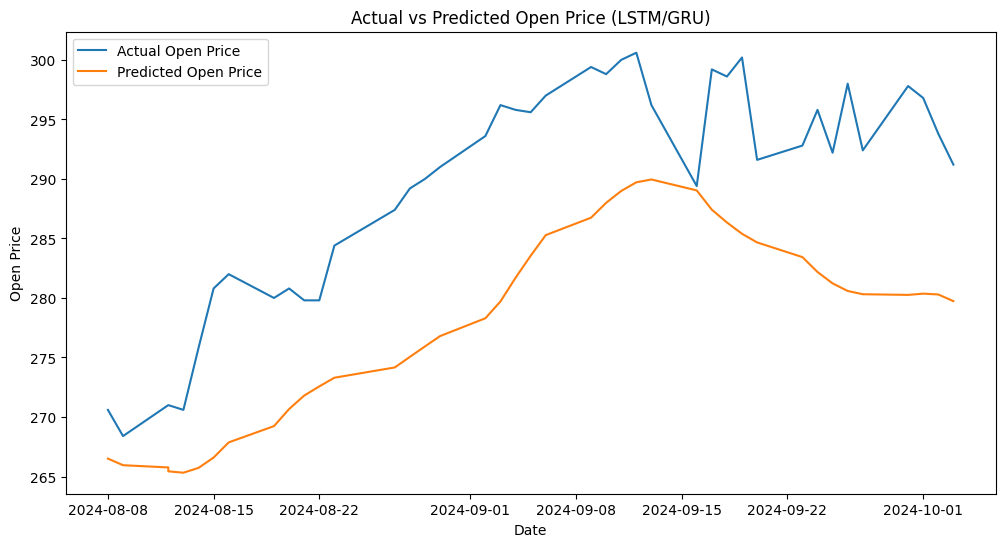

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()
data['Volatility'] = data['Open'].rolling(window=10).std()

# Drop missing values after feature engineering
data.dropna(inplace=True)

# Scaling the features for LSTM/GRU
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Creating sequences (input and target for LSTM/GRU)
def create_sequences(data, target_column, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, target_column])  # Target is the 'Open' price
    return np.array(X), np.array(y)

# Set target column index (here, 'Open' is the 0th column)
target_column = 0
sequence_length = 60

X, y = create_sequences(scaled_data, target_column, sequence_length)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM/GRU input (samples, time steps, features)
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

# Build the LSTM/GRU Model
model = Sequential()

# LSTM or GRU layers
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (single output for the 'Open' price)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict on test data
y_pred = model.predict(X_test)

# Inverse scaling to get the original price
y_test_scaled = np.zeros((len(y_test), scaled_data.shape[1]))
y_test_scaled[:, target_column] = y_test
y_test_original = scaler.inverse_transform(y_test_scaled)[:, target_column]

y_pred_scaled = np.zeros((len(y_pred), scaled_data.shape[1]))
y_pred_scaled[:, target_column] = y_pred.flatten()
y_pred_original = scaler.inverse_transform(y_pred_scaled)[:, target_column]

# Model Evaluation
lstm_mse = mean_squared_error(y_test_original, y_pred_original)
lstm_mae = mean_absolute_error(y_test_original, y_pred_original)
lstm_rmse = np.sqrt(lstm_mse)

print(f'MSE: {lstm_mse}')
print(f'MAE: {lstm_mae}')
print(f'RMSE: {lstm_rmse}')

# Function to predict the next day's price
def predict_next_day_price(model, last_sequence, scaler, target_column=0):
    # Reshape the last sequence to match the input shape (samples, timesteps, features)
    last_sequence = np.array(last_sequence)
    last_sequence = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))

    # Predict the next day's price
    next_day_scaled = model.predict(last_sequence)

    # Prepare the data for inverse scaling
    next_day_unscaled = np.zeros((1, scaled_data.shape[1]))
    next_day_unscaled[:, target_column] = next_day_scaled

    # Inverse scale to get the original price
    next_day_price = scaler.inverse_transform(next_day_unscaled)[:, target_column][0]

    return next_day_price

# Get the last sequence from the test data
last_sequence = X_test[-1]

# Predict the next day's price
next_day_price = predict_next_day_price(model, last_sequence, scaler)
print(f'Predicted next day open price: {next_day_price}')

# Plot Actual vs Predicted Open Price
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_original, label='Actual Open Price')
plt.plot(data.index[-len(y_pred):], y_pred_original, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price (LSTM/GRU)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()


Training with ARIMA and SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA MSE: 314.5236825147814
ARIMA MAE: 14.702363253284203
ARIMA RMSE: 17.734815547808253


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


SARIMA MSE: 440.08239131618524
SARIMA MAE: 17.375356825782966
SARIMA RMSE: 20.97814079741542


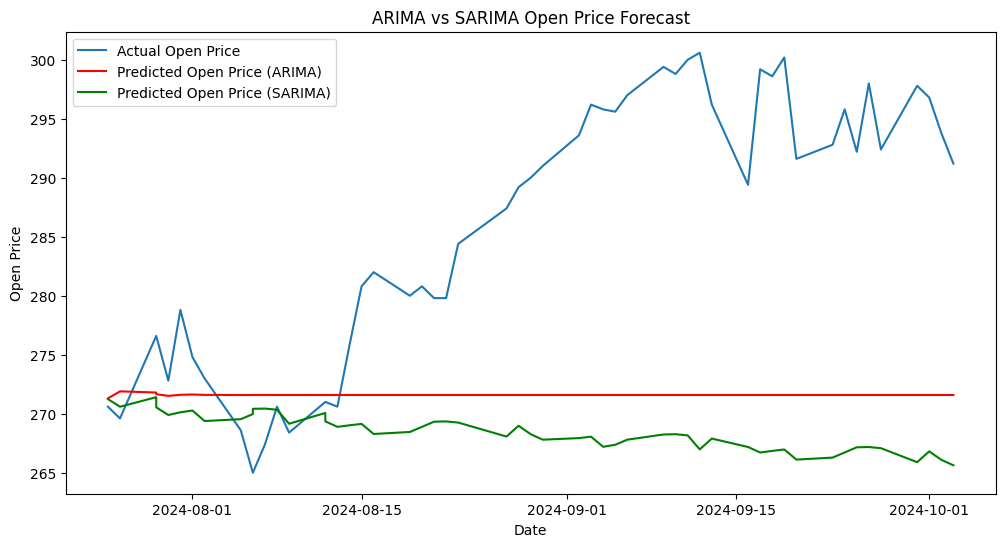

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()
data['Volatility'] = data['Open'].rolling(window=10).std()

# Drop missing values after feature engineering
data.dropna(inplace=True)

# Train-test split for traditional models
train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]

# ARIMA MODEL
def train_arima(train, test):
    model = ARIMA(train['Open'], order=(5, 1, 0))  # Example ARIMA(p=5, d=1, q=0)
    model_fit = model.fit()

    # Forecasting
    y_pred = model_fit.forecast(steps=len(test))

    # Evaluation
    ARIMA_mse = mean_squared_error(test['Open'], y_pred)
    ARIMA_mae = mean_absolute_error(test['Open'], y_pred)
    ARIMA_rmse = np.sqrt(ARIMA_mse)

    print(f'ARIMA MSE: {ARIMA_mse}')
    print(f'ARIMA MAE: {ARIMA_mae}')
    print(f'ARIMA RMSE: {ARIMA_rmse}')

    return y_pred, ARIMA_mse, ARIMA_mae, ARIMA_rmse

# SARIMA MODEL
def train_sarima(train, test):
    model = SARIMAX(train['Open'], order=(5, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit()

    # Forecasting
    y_pred = model_fit.forecast(steps=len(test))

    # Evaluation
    SARIMA_mse = mean_squared_error(test['Open'], y_pred)
    SARIMA_mae = mean_absolute_error(test['Open'], y_pred)
    SARIMA_rmse = np.sqrt(SARIMA_mse)

    print(f'SARIMA MSE: {SARIMA_mse}')
    print(f'SARIMA MAE: {SARIMA_mae}')
    print(f'SARIMA RMSE: {SARIMA_rmse}')

    return y_pred, SARIMA_mse, SARIMA_mae, SARIMA_rmse


# Train ARIMA and store the metrics
arima_pred, ARIMA_mse, ARIMA_mae, ARIMA_rmse = train_arima(train, test)

# Train SARIMA and store the metrics
sarima_pred, SARIMA_mse, SARIMA_mae, SARIMA_rmse = train_sarima(train, test)



# Plot ARIMA vs SARIMA Results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Open'], label='Actual Open Price')
plt.plot(test.index, arima_pred, label='Predicted Open Price (ARIMA)', color='red')
plt.plot(test.index, sarima_pred, label='Predicted Open Price (SARIMA)', color='green')
plt.title('ARIMA vs SARIMA Open Price Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

Found 56 duplicate dates in the dataset.
Duplicates removed.
Data now has 0 duplicate dates.
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-10-04  247.899994  256.000000  246.800003  254.100006  241.990601   
2023-10-05  254.699997  259.600006  254.199997  256.399994  244.180969   
2023-10-06  257.100006  258.209991  249.899994  253.899994  241.800125   
2023-10-07  257.100006  258.209991  249.899994  253.899994  241.800125   
2023-10-08  257.100006  258.209991  249.899994  253.899994  241.800125   

             Volume                                              title  \
Date                                                                     
2023-10-04  9771323                                                NaN   
2023-10-05  8281143                                                NaN   
2023-10-06  7809348  Sainsbury's now more expensive than Waitrose f...   
2023-10-07  780934

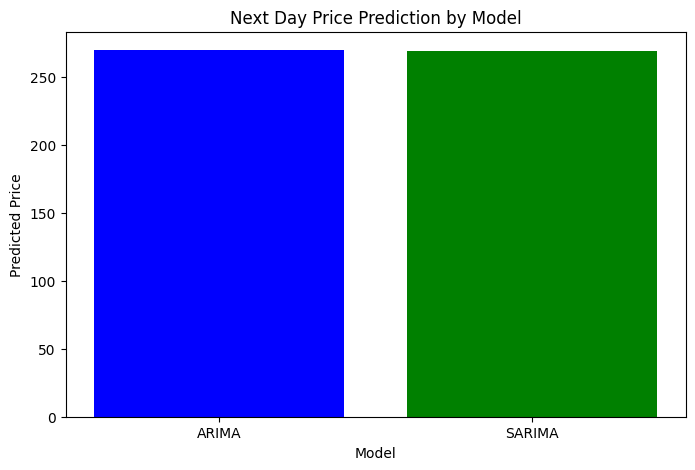

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Check for duplicate dates
duplicate_dates = data.index.duplicated()
if duplicate_dates.any():
    print(f"Found {duplicate_dates.sum()} duplicate dates in the dataset.")
    # Option 1: Remove duplicates (keeping the first occurrence)
    data = data[~duplicate_dates]
    print("Duplicates removed.")

    # Option 2: Handle duplicates by averaging values for the same day
    # data = data.groupby(data.index).mean()

# Ensure no duplicates after removal
print(f"Data now has {data.index.duplicated().sum()} duplicate dates.")

# Ensure there's no missing date index (fill missing dates if necessary)
data = data.asfreq('D', method='pad')  # Fill missing dates with forward-fill

# Split data into training and test sets
train_size = int(0.8 * len(data))
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Check the data structure
print(train.head())
print(test.head())

# ARIMA Model for next day prediction
def train_arima_next_day(train):
    model = ARIMA(train['Open'], order=(5, 1, 0))  # Example ARIMA(p=5, d=1, q=0)
    model_fit = model.fit()

    # Predict next day
    next_day_price = model_fit.forecast(steps=1)[0]
    return next_day_price

# SARIMA Model for next day prediction
def train_sarima_next_day(train):
    model = SARIMAX(train['Open'], order=(5, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit()

    # Predict next day
    next_day_price = model_fit.forecast(steps=1)[0]
    return next_day_price

# Train ARIMA Model and predict the next day's price
#next_day_price_arima = train_arima_next_day(train)
##print(f"Predicted next day price (ARIMA): {next_day_price_arima}")

# Train SARIMA Model and predict the next day's price
#next_day_price_sarima = train_sarima_next_day(train)
#print(f"Predicted next day price (SARIMA): {next_day_price_sarima}")





XGBoost

XGBoost MSE: 9.585206366899722
XGBoost MAE: 2.2665151919958726
XGBoost RMSE: 3.0959984442663604
Predicted next day price (XGBoost): 293.3719787597656


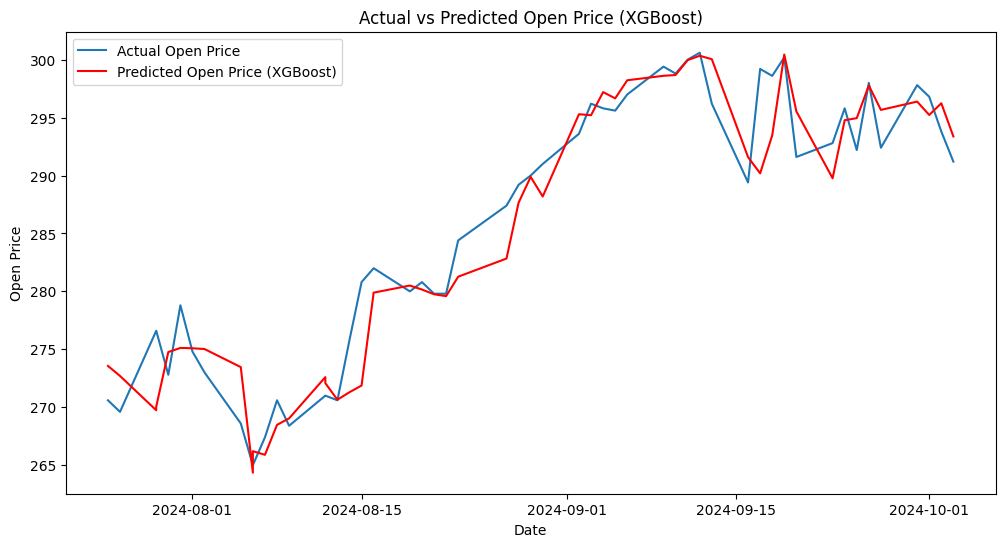

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score', 'High', 'Low', 'Close']]

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()
data['Volatility'] = data['Open'].rolling(window=10).std()

# Drop missing values after feature engineering
data.dropna(inplace=True)

# Select features and target
features = ['sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_roll_mean_3', 'sentiment_roll_std_3',
            'open_roll_mean_3', 'open_roll_std_3', 'MA10', 'MA50', 'Volatility']
target = 'Open'

# Train-test split
train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Initialize and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Model Evaluation
XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_mae = mean_absolute_error(y_test, y_pred)
XGBoost_rmse = np.sqrt(XGBoost_mse)

print(f'XGBoost MSE: {XGBoost_mse}')
print(f'XGBoost MAE: {XGBoost_mae}')
print(f'XGBoost RMSE: {XGBoost_rmse}')

# Function to predict the next day's price
def predict_next_day_xgboost(model, last_data_point):
    next_day_pred = model.predict(last_data_point)
    return next_day_pred[0]

# Prepare the last available data point (reshape for prediction)
last_data_point = X_test.iloc[-1].values.reshape(1, -1)

# Predict the next day's price using XGBoost
#next_day_price_xgboost = predict_next_day_xgboost(xgb_model, last_data_point)
#print(f'Predicted next day price (XGBoost): {next_day_price_xgboost}')

# Plot Actual vs Predicted Open Price (XGBoost)
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Open Price')
plt.plot(test.index, y_pred, label='Predicted Open Price (XGBoost)', color='red')
plt.title('Actual vs Predicted Open Price (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()


Prophet

In [15]:
!pip install -q prophet # install the library

          ds           y
0 2023-10-04  247.899994
1 2023-10-05  254.699997
2 2023-10-06  257.100006
3 2023-10-09  249.199997
4 2023-10-10  253.199997


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf642h9t/edptgm2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf642h9t/fdpjcunv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5565', 'data', 'file=/tmp/tmpuf642h9t/edptgm2w.json', 'init=/tmp/tmpuf642h9t/fdpjcunv.json', 'output', 'file=/tmp/tmpuf642h9t/prophet_model2j25zej7/prophet_model-20241003174414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds
614 2025-09-29
615 2025-09-30
616 2025-10-01
617 2025-10-02
618 2025-10-03
            ds        yhat  yhat_lower  yhat_upper
614 2025-09-29  474.531464  125.137878  802.160841
615 2025-09-30  474.532677  121.429095  799.409670
616 2025-10-01  475.962771  125.092145  804.430741
617 2025-10-02  476.847019  126.444753  804.819880
618 2025-10-03  477.681111  124.382294  808.605153


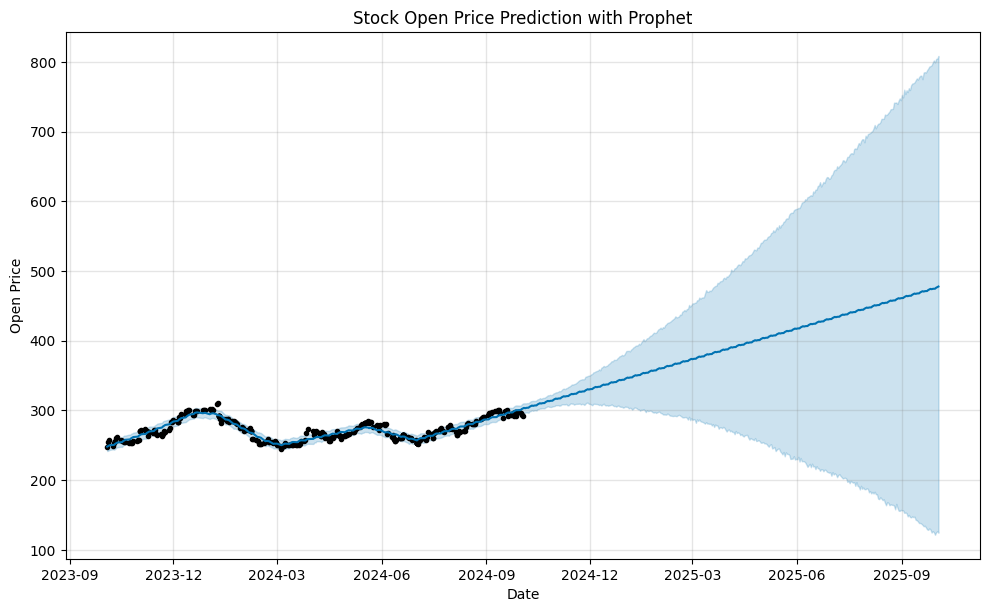

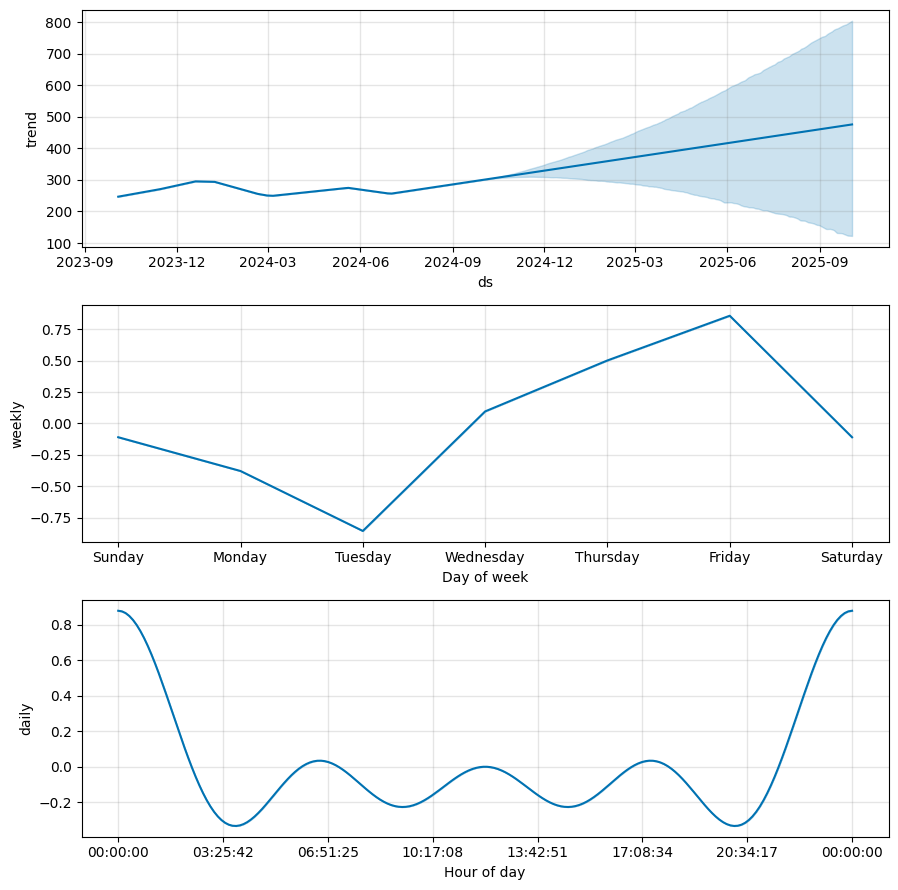

RMSE: 390.2494947975641
RMSE: 19.75473347827209
MAE: 15.534715066979633


In [16]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Prophet requires the data to have two columns: 'ds' (dates) and 'y' (target variable)
# Create a DataFrame with Date as 'ds' and Open price as 'y'
prophet_data = data[['Open']].reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Open': 'y'}, inplace=True)

# Display the first few rows of the data
print(prophet_data.head())

# Initialize the Prophet model
prophet_model = Prophet(daily_seasonality=True)

# Fit the model to the data
prophet_model.fit(prophet_data)

# Make future predictions
# Create a dataframe with future dates
future_dates = prophet_model.make_future_dataframe(periods=365)  # Forecast for the next 365 days
print(future_dates.tail())

# Make predictions
forecast = prophet_model.predict(future_dates)

# Display the predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecasted values
prophet_model.plot(forecast)
plt.title('Stock Open Price Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

# Plot forecast components (trend, yearly seasonality, etc.)
prophet_model.plot_components(forecast)
plt.show()

# Model Evaluation: Calculate RMSE and MAE on historical data
actual = prophet_data['y'].values
predicted = forecast['yhat'][:len(actual)].values  # Prophet gives future predictions, so match the length of actual data

# Calculate RMSE and MAE
prophet_mse = mean_squared_error(actual, predicted)
prophet_rmse = np.sqrt(mean_squared_error(actual, predicted))
prophet_mae = mean_absolute_error(actual, predicted)

print(f'RMSE: {prophet_mse}')
print(f'RMSE: {prophet_rmse}')
print(f'MAE: {prophet_mae}')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf642h9t/u_mzprn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf642h9t/y379ik39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26397', 'data', 'file=/tmp/tmpuf642h9t/u_mzprn0.json', 'init=/tmp/tmpuf642h9t/y379ik39.json', 'output', 'file=/tmp/tmpuf642h9t/prophet_modelptytlt2c/prophet_model-20241003182504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


          ds           y
0 2023-10-04  247.899994
1 2023-10-05  254.699997
2 2023-10-06  257.100006
3 2023-10-09  249.199997
4 2023-10-10  253.199997


18:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds
250 2024-09-30
251 2024-10-01
252 2024-10-02
253 2024-10-03
254 2024-10-04
            ds        yhat  yhat_lower  yhat_upper
250 2024-09-30  300.386842  293.508896  307.269899
251 2024-10-01  300.388054  293.371104  307.121233
252 2024-10-02  301.818148  294.987493  308.664861
253 2024-10-03  302.702396  295.825497  309.736999
254 2024-10-04  303.536488  297.313741  310.231870
Predicted next day price (Prophet): 303.53648791335445


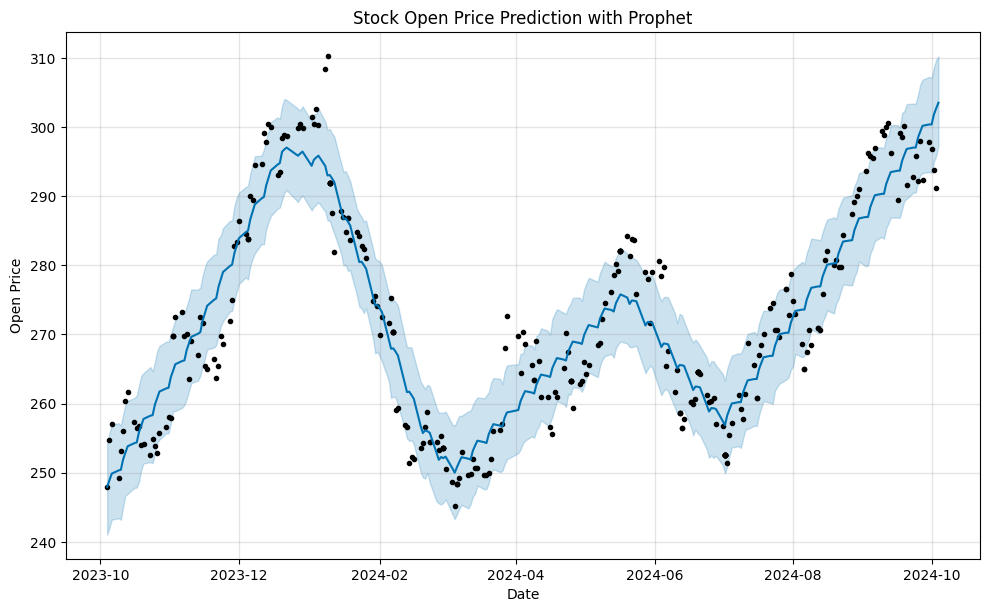

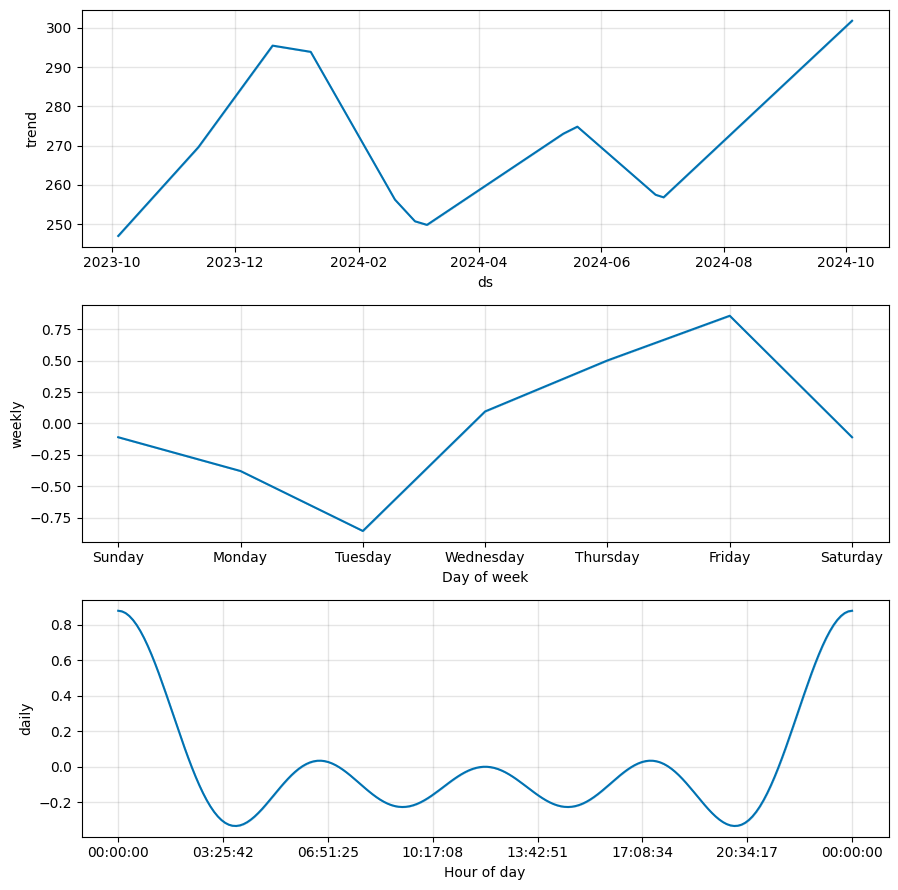

ValueError: Found input variables with inconsistent numbers of samples: [310, 255]

In [40]:
# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Prophet requires the data to have two columns: 'ds' (dates) and 'y' (target variable)
# Create a DataFrame with Date as 'ds' and Open price as 'y'
prophet_data = data[['Open']].reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Open': 'y'}, inplace=True)

# Display the first few rows of the data
print(prophet_data.head())

# Initialize the Prophet model
prophet_model = Prophet(daily_seasonality=True)

# Fit the model to the data
prophet_model.fit(prophet_data)

# Make future predictions
# Create a dataframe with future dates
future_dates = prophet_model.make_future_dataframe(periods=1)  # Forecast for the next 1 day (next day's price)
#print(future_dates.tail())

# Make predictions
forecast = prophet_model.predict(future_dates)



**Choosing the best model based on their errors**

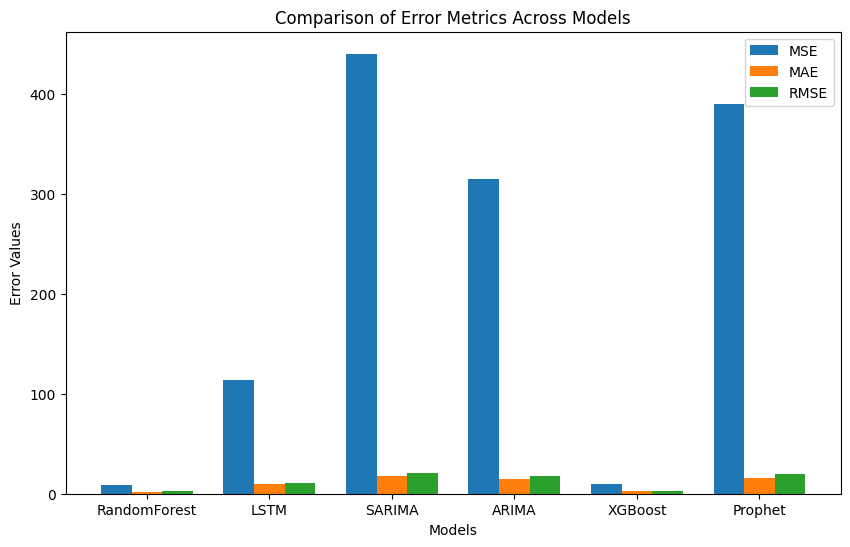

The best model based on average error is: RandomForest


In [17]:

# Define performance metrics for each model
models = ["RandomForest", "LSTM", "SARIMA", "ARIMA", "XGBoost", "Prophet"]
mse = [rf_mse, lstm_mse, SARIMA_mse, ARIMA_mse, XGBoost_mse, prophet_mse]
mae = [rf_mae, lstm_mae, SARIMA_mae, ARIMA_mae, XGBoost_mae, prophet_mae]
rmse = [rf_rmse, lstm_rmse, SARIMA_rmse, ARIMA_rmse, XGBoost_rmse, prophet_rmse]


# Convert 'inf' MSE for Prophet to NaN for better plotting
mse = [np.nan if x == float('inf') else x for x in mse]

# Plotting the errors
x = np.arange(len(models))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each error type
bars1 = ax.bar(x - width, mse, width, label='MSE')
bars2 = ax.bar(x, mae, width, label='MAE')
bars3 = ax.bar(x + width, rmse, width, label='RMSE')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Error Values')
ax.set_title('Comparison of Error Metrics Across Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.show()

# Select the best model based on the lowest average error (MSE, MAE, RMSE)
best_model = None
best_mse = float('inf')
best_mae = float('inf')
best_rmse = float('inf')

for i, model in enumerate(models):
    avg_error = (mse[i] + mae[i] + rmse[i]) / 3  # Aggregate error
    if avg_error < (best_mse + best_mae + best_rmse) / 3:
        best_model = model
        best_mse, best_mae, best_rmse = mse[i], mae[i], rmse[i]

print(f"The best model based on average error is: {best_model}")

**Predicting using the best model**

In [24]:
if best_model == "RandomForest":
    # Assuming 'model' is the trained RandomForest model object
    #Ensure the correct model is loaded for RandomForest predictions!
    future_price = forecast_next_days(new_sentiment_score, loaded_model, initial_data, features, imputer, days=forecast_days)
    print(future_price)

elif best_model == "LSTM":
    # Assuming 'lstm_model' is the trained LSTM model object
    future_price = predict_next_day_price(model, last_sequence, scaler)
    print(future_price)

elif best_model == "SARIMA":
    # Assuming 'model' is the trained SARIMA model object
    future_price = train_sarima_next_day(train)
    print(future_price)

elif best_model == "ARIMA":
    # Assuming 'model' is the trained ARIMA model object
    future_price = train_arima_next_day(train)
    print(future_price)

elif best_model == "XGBoost":
    # Assuming 'model' is the trained XGBoost model object
    future_price = predict_next_day_xgboost(xgb_model, last_data_point)
    print(future_price)

elif best_model == "Prophet":
    # Assuming 'model' is the trained Prophet model object
    future_price = forecast['yhat'].iloc[-1]
    print(future_price)

else:
    print("No model found with the specified name.")
    future_price = None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
279.73481876925325
